In [78]:
import os
import logging
import random
import torch
import torch.nn as nn
import os
import copy
import numpy as np
import warnings
import ray
from ray import air
import ray.tune as tune
from ray.tune.search.bayesopt import BayesOptSearch
from ray.tune.search.optuna import OptunaSearch
from ray.tune.schedulers.hb_bohb import HyperBandForBOHB
from ray.tune.search.bohb import TuneBOHB

import torch
import torch.nn as nn

from sklearn import datasets
from dal_toolbox.utils import seed_everything

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

import ConfigSpace as CS

In [79]:
@torch.no_grad()
def plot_contour(model, X_l, y_l, X_u, y_u, ax=None, feature_extractor=None):
    model.eval()
    model.cpu()
    origin = 'lower'
    if ax:
        plt.sca(ax)
    domain = 3
    xx, yy = torch.meshgrid(torch.linspace(-domain, domain, 51), torch.linspace(-domain, domain, 51), indexing='ij')
    zz = torch.stack((xx.flatten(), yy.flatten()), dim=1)

    if feature_extractor:
        feature_extractor.eval()
        feature_extractor.cpu()
        zz = feature_extractor(zz)
    logits = model(zz)
    probas = logits.softmax(-1)
    zz = probas[:, 1].view(xx.shape)

    plt.scatter(X_l[:, 0], X_l[:, 1], c=y_l, s=50, edgecolors='red')
    plt.scatter(X_u[:, 0], X_u[:, 1], c=y_u, s=15, alpha=.25)
    CS = plt.contourf(xx, yy, zz, alpha=.8, zorder=-1, levels=np.linspace(0, 1, 6), origin=origin)
    CS2 = plt.contour(CS, levels=[0.5], colors='black', origin=origin)
    cbar = plt.colorbar(CS)
    cbar.add_lines(CS2)

In [80]:
def stochasitc_augmentation(X: torch.tensor, noise: float = 1):
    return X + torch.randn_like(X)*noise

class SSLDataset(torch.utils.data.TensorDataset):
    def __init__(self, data, targets, noise):
        self.data = data
        self.targets = targets
        self.noise = noise

    def __getitem__(self, idx):
        X, y = self.data[idx], self.targets[idx]
        return [stochasitc_augmentation(X, self.noise), stochasitc_augmentation(X, self.noise)], y
    
    def __len__(self):
        return self.data.shape[0]


In [81]:
class Net(nn.Module):
    def __init__(self, num_classes: int = 2, feature_dim: int = 128, projection_dim: int = 64):
        super(Net, self).__init__()
        self.base_encoder = nn.Sequential(nn.Linear(2, feature_dim), nn.ReLU())
        self.projector = nn.Sequential(nn.Linear(feature_dim, projection_dim), nn.ReLU())
        self.fc = nn.Linear(feature_dim, num_classes)


    def forward(self, x, get_projections=False):
        x = self.base_encoder(x)
        if get_projections:
            return self.projector(x)
        else:
            return self.fc(x)

In [82]:
LARGE_NUM = 1e9

class NTXent(nn.Module):
    def __init__(self, batch_size, hidden_norm: bool = True, temperature: int = 1.0, n_views: int = 2):
        super(NTXent, self).__init__()
        self.sim = nn.CosineSimilarity(dim=-1)
        self.temperature = temperature
        self.hidden_norm = hidden_norm
        self.device='cuda'
        self.ce_loss = torch.nn.CrossEntropyLoss()
        self.batch_size = batch_size
        self.n_views = n_views

    def forward(self, features):
        labels = torch.cat([torch.arange(self.batch_size) for i in range(self.n_views)], dim=0)
        labels = (labels.unsqueeze(0) == labels.unsqueeze(1)).float()
        labels = labels.to(self.device)

        features = nn.functional.normalize(features, dim=1)

        similarity_matrix = torch.matmul(features, features.T)

        # discard the main diagonal from both: labels and similarities matrix
        mask = torch.eye(labels.shape[0], dtype=torch.bool).to(self.device)
        labels = labels[~mask].view(labels.shape[0], -1)
        similarity_matrix = similarity_matrix[~mask].view(similarity_matrix.shape[0], -1)
        assert similarity_matrix.shape == labels.shape

        # select and combine multiple positives
        positives = similarity_matrix[labels.bool()].view(labels.shape[0], -1)

        # select only the negatives the negatives
        negatives = similarity_matrix[~labels.bool()].view(similarity_matrix.shape[0], -1)

        logits = torch.cat([positives, negatives], dim=1)
        labels = torch.zeros(logits.shape[0], dtype=torch.long).to(self.device)

        logits = logits / self.temperature
        loss = self.ce_loss(logits, labels)

        return loss

In [83]:
def pretrain_one_epoch(model, optimizer, criterion, unsupervised_loader, device='cuda'):
    model.train()
    model.to(device)
    criterion.to(device)

    total_loss, n_samples = 0, 0

    # Train the epoch
    for data, _ in unsupervised_loader:
        data = torch.cat(data, dim=0)
        data = data.to(device)
        batch_size = data.shape[0]

        # Unsupervised loss
        out = model(data, get_projections=True)
        loss = criterion(out)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * batch_size
        n_samples += batch_size

    return {'loss': total_loss/n_samples}

In [84]:
def train_one_epoch(model, optimizer, criterion, supervised_loader, device='cuda'):
    model.train()
    model.to(device)
    criterion.to(device)

    total_loss, n_samples, n_correct = 0, 0, 0 

    # Train the epoch
    for (x, y) in supervised_loader:
        x, y = x.to(device), y.to(device)
        batch_size = x.shape[0]

        out = model(x)
        loss = criterion(out, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * batch_size
        n_samples += batch_size
        n_correct += torch.sum(torch.max(out.softmax(-1), dim=-1)[1] == y).item()

    return {
        'loss':total_loss/n_samples, 
        'acc':n_correct/n_samples
        }

In [85]:
@torch.no_grad()
def evaluate(model, criterion, test_loader, device='cuda'):
    model.eval()
    model.to(device)
    criterion.to(device)

    total_loss, n_samples, n_correct = 0, 0, 0 

    # Train the epoch
    for (x, y) in test_loader:
        x, y = x.to(device), y.to(device)
        batch_size = x.shape[0]

        out = model(x)
        loss = criterion(out, y)

        total_loss += loss.item() * batch_size
        n_samples += batch_size
        n_correct += torch.sum(torch.max(out.softmax(-1), dim=-1)[1] == y).item()

    return {
        'loss':total_loss/n_samples, 
        'acc':n_correct/n_samples
        }

In [86]:
def build_datasets(args, seed=42):
    X, y = datasets.make_moons(args['n_samples'], noise=.1, random_state=seed)
    X = torch.from_numpy(X).float()
    y = torch.from_numpy(y).long()

    random.seed(seed)
    test_indices = random.sample(range(X.shape[0]), k =args['n_test_samples'])
    train_indices = [i for i in range(X.shape[0]) if i not in test_indices]
    labeled_indices = random.sample(train_indices, k=args['n_labeled_samples'])
    unlabeled_indices = [i for i in train_indices if i not in labeled_indices]
    labeled_ds = torch.utils.data.TensorDataset(X[labeled_indices], y[labeled_indices])
    unlabeled_ds = SSLDataset(X[train_indices], y[train_indices], noise=args['noise'])
    test_ds = torch.utils.data.TensorDataset(X[test_indices], y[test_indices])

    ds_info = {
        'train_indices':train_indices,
        'test_indices':test_indices,
        'labeled_indices':labeled_indices,
        'unlabeled_indices':unlabeled_indices,
        'n_classes':2,
        'X':X,
        'y':y
    }

    return labeled_ds, unlabeled_ds, test_ds, ds_info

In [87]:
def build_pretrain_search_space(args):
    points_to_evaluate = None
    search_space = {
        "lr": tune.uniform(1e-3, .5),
        "weight_decay": tune.uniform(0, .5),
        "noise": tune.uniform(0, .1)
    }
    return search_space, points_to_evaluate

def build_supervised_search_space(args):
    points_to_evaluate = None
    search_space = {
        "lr": tune.uniform(1e-3, .5),
        "weight_decay": tune.uniform(0, .5)
    }
    return search_space, points_to_evaluate

In [88]:
def pretrain(config, args):
    args['pretrain_learning_rate'] = float(config['lr'])
    args['pretrain_weight_decay'] = float(config['weight_decay'])
    args['noise'] = float(config['noise'])

    _, unlabeled_ds, _, _ = build_datasets(args)

    torch.manual_seed(args['random_seed'])
    model = Net(feature_dim=args['feature_dim'], projection_dim=args['projection_dim'])
    pretrain_optimizer = torch.optim.SGD(model.parameters(), lr=args['pretrain_learning_rate'], momentum=0.9, weight_decay=args['pretrain_weight_decay'], nesterov=True)
    pretrain_criterion = NTXent(batch_size=args['pretrain_batch_size'], temperature=args['temperature'], hidden_norm=True)
    pretrain_lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(pretrain_optimizer, T_max=args['pretrain_n_epochs']-args['n_epochs_warmup'])
    pretrain_loader = torch.utils.data.DataLoader(unlabeled_ds, batch_size=args['pretrain_batch_size'], shuffle=True, drop_last=True)

    for i in range(args['pretrain_n_epochs']):
        pretrain_stats = pretrain_one_epoch(model, pretrain_optimizer, pretrain_criterion, pretrain_loader)
        if i > args['n_epochs_warmup']:
            pretrain_lr_scheduler.step()

    return {'unsup_loss':pretrain_stats['loss']}

In [89]:
def train(config, args, labeled_ds, val_ds, pretrained_model_state):
    args['supervised_learning_rate'] = float(config['lr'])
    args['supervised_weight_decay'] = float(config['weight_decay'])

    model = Net(feature_dim=args['feature_dim'], projection_dim=args['projection_dim'])
    model.load_state_dict(pretrained_model_state)

    supervised_optimizer = torch.optim.SGD(model.fc.parameters(), lr=args['supervised_learning_rate'], momentum=0.9, weight_decay=args['supervised_weight_decay'], nesterov=True)
    supervised_lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(supervised_optimizer, T_max=args['supervised_n_epochs'])
    supervised_criterion = nn.CrossEntropyLoss()

    train_loader = torch.utils.data.DataLoader(labeled_ds, batch_size=args['supervised_batch_size'], shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_ds, batch_size=64)

    for j in range(args['supervised_n_epochs']):
        train_one_epoch(model, supervised_optimizer, supervised_criterion, train_loader)
        supervised_lr_scheduler.step()

    test_stats = evaluate(model, supervised_criterion, val_loader)

    return {'val_acc':test_stats['acc']}

In [90]:
args = {
    'n_samples':400,
    'n_test_samples':100,
    'n_labeled_samples':8,

    'feature_dim':64,
    'projection_dim':64,
    'n_classes':2,

    'pretrain_batch_size':64,
    'pretrain_learning_rate':1e-1,
    'pretrain_weight_decay':5e-4,
    'n_epochs_warmup':10,
    'pretrain_n_epochs':400,
    'noise':0.05,
    'temperature':1,
    'step_size':25,

    'supervised_n_epochs':100,
    'supervised_batch_size':64,
    'supervised_learning_rate':1e-1,
    'supervised_weight_decay':5e-4,
    
    'random_seed':42,
}

In [91]:
from ray.tune import Trainable
import json

class MyTrainableClass(Trainable):
    """Example agent whose learning curve is a random sigmoid.

    The dummy hyperparameters "width" and "height" determine the slope and
    maximum reward value reached.
    """

    def setup(self, config):
        args = config['args']
        self.args = args
        self.timestep = 0
        self.unlabeled_ds = build_datasets(args)[1]
        self.unlabeled_ds.noise = config['noise']
        torch.manual_seed(args['random_seed'])
        self.model = Net(args['n_classes'], args['feature_dim'], args['projection_dim'])
        self.pretrain_optimizer = torch.optim.SGD(self.model.parameters(), lr=config['lr'], momentum=0.9, weight_decay=config['wd'], nesterov=True)
        self.pretrain_criterion = NTXent(batch_size=args['pretrain_batch_size'], temperature=args['temperature'], hidden_norm=True)
        self.pretrain_lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(self.pretrain_optimizer, T_max=args['pretrain_n_epochs']-args['n_epochs_warmup'])
        self.pretrain_loader = torch.utils.data.DataLoader(self.unlabeled_ds, batch_size=args['pretrain_batch_size'], shuffle=True, drop_last=True)


    def step(self):
        for i in range(self.args['step_size']):
            pretrain_stats = pretrain_one_epoch(self.model, self.pretrain_optimizer, self.pretrain_criterion, self.pretrain_loader)
            if self.timestep > args['n_epochs_warmup']:
                self.pretrain_lr_scheduler.step()
        self.timestep += 1
        return {'loss': pretrain_stats['loss']}

    def save_checkpoint(self, checkpoint_dir):
        path = os.path.join(checkpoint_dir, "checkpoint")
        with open(path, "w") as f:
            f.write(json.dumps({"timestep": self.timestep}))
        return path

    def load_checkpoint(self, checkpoint_path):
        with open(checkpoint_path) as f:
            self.timestep = json.loads(f.read())["timestep"]

In [92]:
warnings.filterwarnings("ignore", category=FutureWarning)
RAY_DEDUP_LOGS=0

# Init ray, if we are using slurm, set cpu and gpus
adress = None
num_cpus = int(os.environ.get('SLURM_CPUS_PER_TASK', 1))
num_gpus = torch.cuda.device_count()
if ray.is_initialized():
    ray.shutdown()
ray.init(address=adress, num_cpus=num_cpus, num_gpus=num_gpus, ignore_reinit_error=True)

assert args['pretrain_n_epochs']%args['step_size'] == 0, 'n_epochs pretrain should be a multiple of step size'

config = {
    "args": args,
    "iterations": args['pretrain_n_epochs']//args['step_size'],
    "lr": tune.uniform(1e-4, .1),
    "wd": tune.uniform(0, .1),
    "noise": tune.uniform(0, .1),
    "feature_dim": tune.choice(range(129)),
    "projection_dim": tune.choice(range(129))
}

scaling_cfg = air.ScalingConfig(
    resources_per_worker={'cpu': 1, 'gpu': 1},
)

bohb_hyperband = HyperBandForBOHB(
    time_attr="training_iteration",
    max_t=args['pretrain_n_epochs']//args['step_size'],
    reduction_factor=4,
    stop_last_trials=False,
)

bohb_search = TuneBOHB(
    seed=args['random_seed']
)
bohb_search = tune.search.ConcurrencyLimiter(bohb_search, max_concurrent=4)

tuner = tune.Tuner(
    trainable=tune.with_resources(MyTrainableClass, tune.PlacementGroupFactory([
         {"CPU": 0.25, "GPU": 0.25},
         {"CPU": 0.25, "GPU": 0.25},
         {"CPU": 0.25, "GPU": 0.25},
         {"CPU": 0.25, "GPU": 0.25},
     ])),
    run_config=air.RunConfig(name="bohb_test", stop={"training_iteration": 400}),
    tune_config=tune.TuneConfig(
        metric="loss",
        mode="min",
        scheduler=bohb_hyperband,
        search_alg=bohb_search,
        num_samples=100
    ),
    param_space=config,
)
results = tuner.fit()

print("Best hyperparameters found were: ", results.get_best_result().config)
opt_pretrain_config = results.get_best_result().config

2023-04-27 11:44:41,855	INFO worker.py:1616 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


Trial name,date,done,hostname,iterations_since_restore,loss,node_ip,pid,time_since_restore,time_this_iter_s,time_total_s,timestamp,training_iteration,trial_id
MyTrainableClass_0b3cd1ca,2023-04-27_11-45-46,False,denis-MS-7C37,1,2.70395,141.51.131.177,15525,3.88277,3.88277,3.88277,1682588746,1,0b3cd1ca
MyTrainableClass_25a990a7,2023-04-27_11-45-05,False,denis-MS-7C37,1,3.97047,141.51.131.177,14807,2.29061,2.29061,2.29061,1682588705,1,25a990a7
MyTrainableClass_307228e9,2023-04-27_11-44-56,False,denis-MS-7C37,1,5.54121,141.51.131.177,14647,1.88763,1.88763,1.88763,1682588696,1,307228e9
MyTrainableClass_3c52ece0,2023-04-27_11-45-24,False,denis-MS-7C37,1,2.70805,141.51.131.177,15154,3.85033,3.85033,3.85033,1682588724,1,3c52ece0
MyTrainableClass_3d1af245,2023-04-27_11-45-09,False,denis-MS-7C37,1,5.03179,141.51.131.177,14886,1.87277,1.87277,1.87277,1682588709,1,3d1af245
MyTrainableClass_3ef2d8bb,2023-04-27_11-44-46,False,denis-MS-7C37,1,4.14313,141.51.131.177,14448,2.27982,2.27982,2.27982,1682588686,1,3ef2d8bb
MyTrainableClass_549de65a,2023-04-27_11-45-56,False,denis-MS-7C37,1,4.14313,141.51.131.177,15696,2.2545,2.2545,2.2545,1682588756,1,549de65a
MyTrainableClass_6b84ed53,2023-04-27_11-45-29,False,denis-MS-7C37,1,4.14276,141.51.131.177,15231,2.25625,2.25625,2.25625,1682588729,1,6b84ed53
MyTrainableClass_7630cf98,2023-04-27_11-45-14,False,denis-MS-7C37,1,4.84419,141.51.131.177,14965,1.96302,1.96302,1.96302,1682588714,1,7630cf98
MyTrainableClass_a4b78e88,2023-04-27_11-45-00,False,denis-MS-7C37,1,5.67237,141.51.131.177,14726,1.80274,1.80274,1.80274,1682588700,1,a4b78e88


(MyTrainableClass pid=15890) 2023-04-27 11:46:12,067	INFO trainable.py:913 -- Restored on 141.51.131.177 from checkpoint: /tmp/checkpoint_tmp_3aaa4e6c4559472892c6dea46061e025
(MyTrainableClass pid=15890) 2023-04-27 11:46:12,067	INFO trainable.py:922 -- Current state after restoring: {'_iteration': 1, '_timesteps_total': None, '_time_total': 3.901676654815674, '_episodes_total': None}
(MyTrainableClass pid=16090) 2023-04-27 11:46:36,084	INFO trainable.py:922 -- Current state after restoring: {'_iteration': 1, '_timesteps_total': None, '_time_total': 3.850332498550415, '_episodes_total': None}
(MyTrainableClass pid=16090) 2023-04-27 11:46:36,084	INFO trainable.py:922 -- Current state after restoring: {'_iteration': 1, '_timesteps_total': None, '_time_total': 3.850332498550415, '_episodes_total': None}
(MyTrainableClass pid=16172) 2023-04-27 11:46:47,079	INFO trainable.py:913 -- Restored on 141.51.131.177 from checkpoint: /tmp/checkpoint_tmp_e0ca426068cb42e3955eb2f6736454e7
(MyTrainableCl

Best hyperparameters found were:  {'args': {'n_samples': 400, 'n_test_samples': 100, 'n_labeled_samples': 8, 'feature_dim': 64, 'projection_dim': 64, 'n_classes': 2, 'pretrain_batch_size': 64, 'pretrain_learning_rate': 0.1, 'pretrain_weight_decay': 0.0005, 'n_epochs_warmup': 10, 'pretrain_n_epochs': 400, 'noise': 0.05, 'temperature': 1, 'step_size': 25, 'supervised_n_epochs': 100, 'supervised_batch_size': 64, 'supervised_learning_rate': 0.1, 'supervised_weight_decay': 0.0005, 'random_seed': 42}, 'iterations': 16, 'lr': 0.015683852581586645, 'wd': 0.08661761457749352, 'noise': 0.005808361216819946, 'batch_size': 8}


In [ ]:
labeled_ds, unlabeled_ds, val_ds, ds_info = build_datasets(args)

args['pretrain_learning_rate'] = float(opt_pretrain_config['lr'])
args['pretrain_weight_decay'] = float(opt_pretrain_config['wd'])
args['pretrain_batch_size'] = int(opt_pretrain_config['batch_size'])
args['noise'] = float(opt_pretrain_config['noise'])
unlabeled_ds.noise = args['noise']

torch.manual_seed(args['random_seed'])
model = Net(feature_dim=args['feature_dim'], projection_dim=args['projection_dim'])
initial_model_state = copy.deepcopy(model.state_dict())
pretrain_optimizer = torch.optim.SGD(model.parameters(), lr=args['pretrain_learning_rate'], momentum=0.9, weight_decay=args['pretrain_weight_decay'], nesterov=True)
pretrain_criterion = NTXent(batch_size=args['pretrain_batch_size'], temperature=args['temperature'], hidden_norm=True)
pretrain_lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(pretrain_optimizer, T_max=args['pretrain_n_epochs']-args['n_epochs_warmup'])
pretrain_loader = torch.utils.data.DataLoader(unlabeled_ds, batch_size=args['pretrain_batch_size'], shuffle=True, drop_last=True)

history_fe = []

for i in tqdm(range(args['pretrain_n_epochs'])):
    pretrain_stats = pretrain_one_epoch(model, pretrain_optimizer, pretrain_criterion, pretrain_loader)
    history_fe.append({'train_stats':pretrain_stats})
    if i > args['n_epochs_warmup']:
        pretrain_lr_scheduler.step()

pretrained_model_state = copy.deepcopy(model.state_dict())

  0%|          | 0/400 [00:00<?, ?it/s]

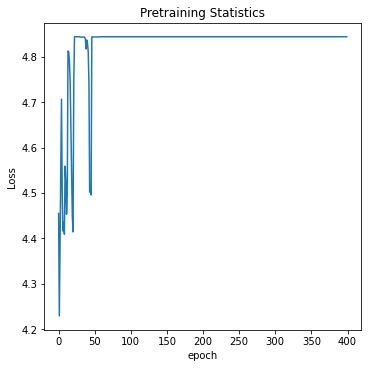

In [ ]:
plt.figure(figsize=(5,5), constrained_layout=True)
plt.title("Pretraining Statistics")
plt.plot([h['train_stats']['loss'] for h in history_fe])
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.show()

In [ ]:
# Init ray, if we are using slurm, set cpu and gpus
adress = None
num_cpus = int(os.environ.get('SLURM_CPUS_PER_TASK', 1))
num_gpus = torch.cuda.device_count()
if ray.is_initialized():
    ray.shutdown()
ray.init(address=adress, num_cpus=num_cpus, num_gpus=num_gpus, ignore_reinit_error=True)

# Setup Search space
search_space, points_to_evaluate = build_supervised_search_space(args)
search_alg = OptunaSearch()
tune_config = tune.TuneConfig(search_alg=search_alg, num_samples=25,  metric='val_acc', mode='max')

# Setup objective
objective = tune.with_resources(train, resources={'cpu': 1, 'gpu': 1})
objective = tune.with_parameters(objective, args=args, labeled_ds=labeled_ds, val_ds=val_ds, pretrained_model_state=pretrained_model_state)

# Start hyperparameter search
tuner = tune.Tuner(
    objective,
    tune_config=tune_config,
    param_space=search_space
)
results = tuner.fit()
print('Best Supervised Stats: {}'.format(results.get_best_result().metrics))
print('Best Validation Acc Hyperparameter: {}'.format(results.get_best_result(metric="val_acc", mode="max").config))
opt_supervised_config = results.get_best_result().config

2023-04-27 11:27:18,647	INFO worker.py:1616 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
[I 2023-04-27 11:27:18,980] A new study created in memory with name: optuna


2023-04-27 11:27:24,767	INFO tune.py:945 -- Total run time: 5.79 seconds (5.76 seconds for the tuning loop).


Best Supervised Stats: {'val_acc': 0.53, 'time_this_iter_s': 1.761779546737671, 'done': True, 'training_iteration': 1, 'trial_id': 'f2ad089b', 'date': '2023-04-27_11-27-22', 'timestamp': 1682587642, 'time_total_s': 1.761779546737671, 'pid': 10239, 'hostname': 'denis-MS-7C37', 'node_ip': '141.51.131.177', 'config': {'lr': 0.27290722907196224, 'weight_decay': 0.17444293921397147}, 'time_since_restore': 1.761779546737671, 'iterations_since_restore': 1, 'experiment_tag': '1_lr=0.2729,weight_decay=0.1744'}
Best Validation Acc Hyperparameter: {'lr': 0.27290722907196224, 'weight_decay': 0.17444293921397147}


In [ ]:
args['supervised_learning_rate'] = opt_supervised_config['lr']
args['supervised_weight_decay'] = opt_supervised_config['weight_decay']

model.load_state_dict(pretrained_model_state)

# freeze all layers but the last fc
for name, param in model.named_parameters():
    if name not in ['fc.weight', 'fc.bias']:
        param.requires_grad = False

supervised_optimizer = torch.optim.SGD(model.parameters(), lr=args['supervised_learning_rate'], momentum=0.9, weight_decay=args['supervised_weight_decay'], nesterov=True)
supervised_lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(supervised_optimizer, T_max=args['supervised_n_epochs'])
supervised_criterion = nn.CrossEntropyLoss()

train_loader = torch.utils.data.DataLoader(labeled_ds, batch_size=args['supervised_batch_size'], shuffle=True)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=64)

history_fc = []

for j in range(args['supervised_n_epochs']):
    train_stats = train_one_epoch(model, supervised_optimizer, supervised_criterion, train_loader)
    test_stats = evaluate(model, supervised_criterion, val_loader)
    supervised_lr_scheduler.step()
    history_fc.append(
        {
        'train_stats': train_stats,
        'test_stats':test_stats
        }
    )

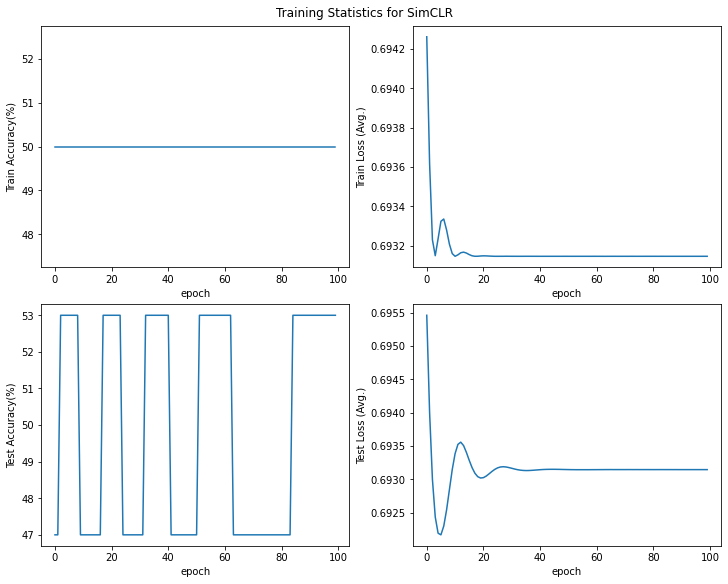

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(10,8), constrained_layout=True)
fig.suptitle('Training Statistics for SimCLR')
ax[0][0].plot([h['train_stats']['acc']*100 for h in history_fc])
ax[0][0].set_xlabel('epoch')
ax[0][0].set_ylabel('Train Accuracy(%)')
ax[0][1].plot([h['train_stats']['loss'] for h in history_fc])
ax[0][1].set_xlabel('epoch')
ax[0][1].set_ylabel('Train Loss (Avg.)')

ax[1][0].plot([h['test_stats']['acc']*100 for h in history_fc])
ax[1][0].set_xlabel('epoch')
ax[1][0].set_ylabel('Test Accuracy(%)')
ax[1][1].plot([h['test_stats']['loss'] for h in history_fc])
ax[1][1].set_xlabel('epoch')
ax[1][1].set_ylabel('Test Loss (Avg.)')
plt.show()

In [ ]:
## Comparison to basic NN Fully supervised training
n_epochs = 100
batch_size = 8
learning_rate = 1e-2
momentum = 0.9
weight_decay = 5e-2

baseline = Net(num_classes=2, feature_dim=args["feature_dim"], projection_dim=args["projection_dim"])
baseline.load_state_dict(initial_model_state)
optimizer = torch.optim.SGD(baseline.fc.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay, nesterov=True)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)
dataloader = torch.utils.data.DataLoader(labeled_ds, batch_size=batch_size, shuffle=True, drop_last=True)
dataloader_val = torch.utils.data.DataLoader(val_ds, batch_size=64)
criterion = nn.CrossEntropyLoss()

history = []

for i in range(n_epochs):
    train_stats = train_one_epoch(model=baseline, supervised_loader=dataloader, criterion=criterion, optimizer=optimizer, device='cuda')
    test_stats = evaluate(model=baseline, test_loader=dataloader_val, criterion=criterion, device='cuda')
    history.append(
        {
        'train_stats': train_stats,
        'test_stats':test_stats
        }
    )
    lr_scheduler.step()

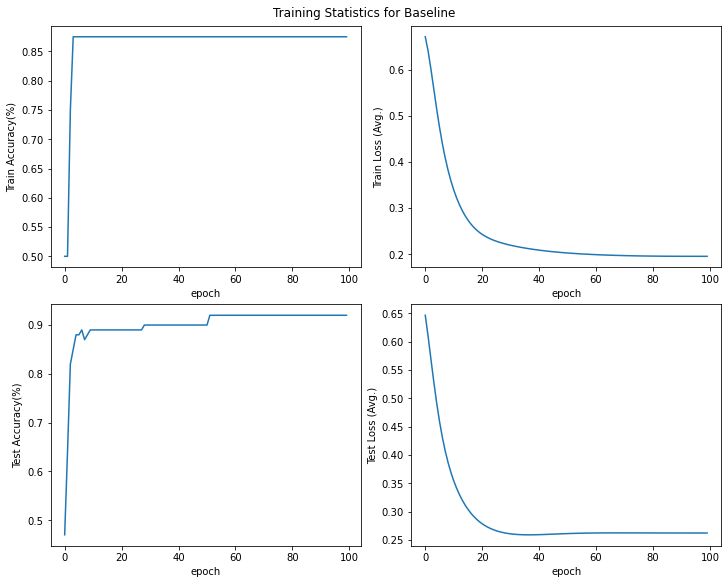

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(10,8), constrained_layout=True)
fig.suptitle('Training Statistics for Baseline')
ax[0][0].plot([h['train_stats']['acc'] for h in history])
ax[0][0].set_xlabel('epoch')
ax[0][0].set_ylabel('Train Accuracy(%)')
ax[0][1].plot([h['train_stats']['loss'] for h in history])
ax[0][1].set_xlabel('epoch')
ax[0][1].set_ylabel('Train Loss (Avg.)')

ax[1][0].plot([h['test_stats']['acc'] for h in history])
ax[1][0].set_xlabel('epoch')
ax[1][0].set_ylabel('Test Accuracy(%)')
ax[1][1].plot([h['test_stats']['loss'] for h in history])
ax[1][1].set_xlabel('epoch')
ax[1][1].set_ylabel('Test Loss (Avg.)')
plt.show()

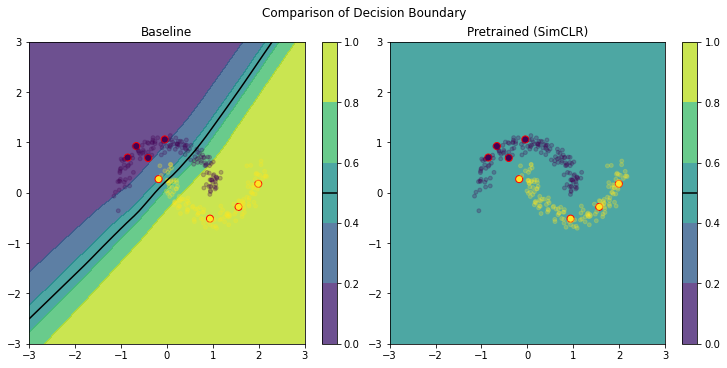

In [ ]:
X, y, labeled_indices, unlabeled_indices = ds_info['X'], ds_info['y'], ds_info['labeled_indices'], ds_info['unlabeled_indices']

fig, ax = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True)
fig.suptitle("Comparison of Decision Boundary")
plot_contour(baseline, X[labeled_indices], y[labeled_indices], X[unlabeled_indices], y[unlabeled_indices], ax[0])
ax[0].set_title("Baseline")
plot_contour(model, X[labeled_indices], y[labeled_indices], X[unlabeled_indices], y[unlabeled_indices], ax[1])
ax[1].set_title("Pretrained (SimCLR)")
plt.show()